## Deterministic equivalent $R_{n,p}$ for a random feature model

In a random feature model, the predictor is selected via ERM from an hypothesis class $\mathcal{F}_{RF}$:
$$
\mathcal{F}_{RF} = \{f(\vec x; \vec a) = \frac{1}{\sqrt{p}} \sum_{j=1}^p a_j \phi(\vec x; \vec w_j) : \vec a \in \mathbb{R}^p\}
$$
where $\phi(\vec x; \vec w_j)$ are random functions (the randonmess come from the parameters $\vec w_j \sim \mu(\vec w)$, fixed during training)

The input set is provided once a pair of training points $\{\vec x_i\}_{i=1,\dots, N} \subset X$, and labels $\{y_i\}$ is given. The training is performed via ERM, i.e. looking for the value of $\vec a$ that minimizes the empirical risk:
$$
R(f_\star, \mathbf{X}, \mathbf{W}, \epsilon, \lambda) = \mathbb{E}_{\vec x \in \mu(\vec x)}[f_\star (\vec x) - \hat f(\vec x;\vec a)]^2
$$
given $f_\star (\vec x)$ the Bayes predictor


Let us define the Fredholm operator $\mathbb{T}: L_2(X) \to L_2(W)$. Given a function $h(\vec x)$ defined on the input space,
$$
(\mathbb{T} h) (\vec w) = \int d^d \vec x p_x(\vec x) \phi (\vec x; \vec w) h(\vec x)
$$
It can be diagonalized through a set of orthonormal basis of  $L_2(X)$ and $L_2(W)$:
$$
\mathbb{T} = \sum_k \xi_k |\phi_k \rangle \langle \psi_k |
$$
where $|\phi_k \rangle $ lives in $L_2(W)$ and $|\psi_k \rangle \in L_2(X)$. Given a target function $f_\star = \sum_m \beta_{\star, m} |\psi_m \rangle$, then the operator $\mathbb{T}$ applied to $f_\star$ yields:
$$
(\mathbb{T} f_\star) (\vec w) = \sum_k \sum_m  \xi_k \beta_{\star, m}  |\phi_k \rangle \langle \psi_k | \psi_m \rangle = \sum_k  \xi_k \beta_{\star, k}  |\phi_k \rangle
$$


We have everything we need to compute the deterministic equivalent. From Definition (1):
$$
1 + \frac{n}{p} - \sqrt{\Bigl(1-\frac{n}{p}\Bigr)^2+4\frac{\lambda}{p\nu_2}} =\frac{2}{p} \sum_k \frac{\xi_k^2}{\xi_k^2 + \nu_2}
$$
and $\nu_1$:
$$
\nu_1 = \frac{\nu_2}{2}\Bigl[1-\frac{n}{p} + \sqrt{\Bigl( 1-\frac{n}{p}\Bigr)^2 + 4\frac{\lambda}{p \nu_2}}\Bigr]
$$




### Step 1: setting $\Sigma$

In this notebook, we will use the *Gaussian design* procedure illustrated in Appendix C.2. We assume $\Sigma$ and $\beta_\star$ are power-law distributed and design an algorithm to obtain a training set $\vec x$ and some feature maps $\phi(\vec x; \vec w)$ built in such a way that the spectrum of $\mathbb{T}$ is precisely given by the target $\Sigma$. 

Let's fix:
$$
\xi_k^2 = k^{-2\alpha}
$$
$$
\beta_{\star, k} = k^{-\gamma}
$$

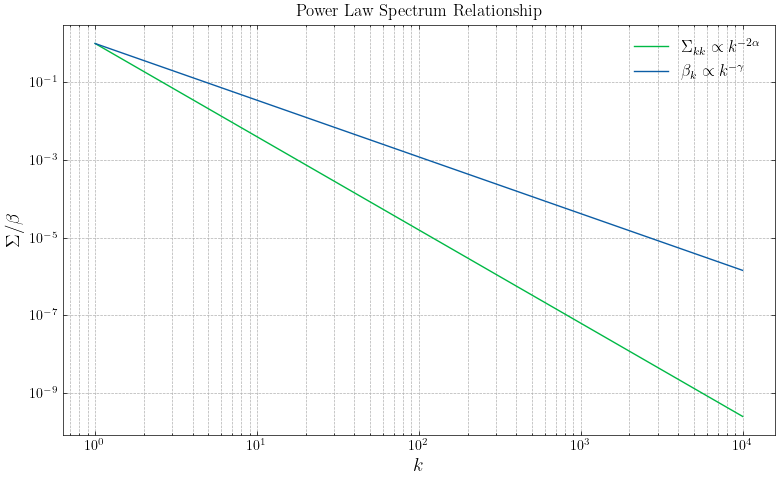

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

cutoff = 10**4          # Finite cutoff, I've used the same as in the paper 
alpha, gamma = 1.2, 1.46
Sigma = np.array([i**(-2*alpha) for i in range(1, cutoff+1)])
beta = np.array([i**(-gamma) for i in range(1, cutoff+1)])

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(np.arange(1, cutoff+1), Sigma, label=r'$\Sigma_{{kk}} \propto k^{-2\alpha}$', color='C1')
ax.loglog(np.arange(1, cutoff+1), beta, label=r'$\beta_k \propto k^{-\gamma}$', color='C0')
ax.set_ylabel(r'$\Sigma / \beta$', fontsize=14)
ax.set_xlabel(r'$k$', fontsize=14)
ax.set_title('Power Law Spectrum Relationship')
ax.legend(fontsize=12)
ax.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

### Step 2: computing $\nu_1, \nu_2$

I will use Eq. (167), (168) at Pag. 57. Given a $\nu_2^0 > 0$,
$$
\nu_1^{t+1} = \frac{\nu_2^t}{2}\Bigl[1-\frac{n}{p} + \sqrt{\Bigl(1-\frac{n}{p}\Bigr)^2 + 4\frac{\lambda}{p \nu_2^t}}\Bigr]
$$
$$
\nu_2^{t+1} = \nu_1^{t+1} + \frac{\nu_2^t}{p}\sum_k \frac{\xi_k^2}{\xi_k^2+\nu_2^t}
$$
and wait for convergence. Given $\nu_1, \nu_2$, one can finally compute the deterministic equivalent

In [2]:
def solveNu1Nu2(n : int, p : int, lambd : float, Sigma : np.array, tolerance=1e-10, maxIter=1000):
    nu2 = 1
    nu1 = 0
    for it in range(maxIter):
        nu1_new = 0.5 * nu2 * (1 - float(n)/float(p) + np.sqrt( (1-float(n)/float(p))**2 + 4 * lambd / (p*nu2)) )
        nu2_new = nu1_new + nu2 / p * np.sum( Sigma / (Sigma + nu2) )
        if abs(nu2_new - nu2) < tolerance and abs(nu1_new - nu1) < tolerance:
            break
        nu2 = nu2_new
        nu1 = nu1_new
    return nu1, nu2

# Compute the deterministic equivalent of variance and bias given some parameters (n, p, \lambda, \sigma, \Sigma, \beta)
def computeDeterministicEquivalent(n : int, p : int, lambd : float, sigma : float, Sigma : np.array, beta : np.array):
    nu1, nu2 = solveNu1Nu2(n, p, lambd, Sigma)

    Y12 = float(p)/float(n) * ( (1-nu1/nu2)**2 + (nu1/nu2)**2 * (np.sum(Sigma**2 / (Sigma + nu2)**2)) / (p - np.sum(Sigma**2 / (Sigma + nu2)**2)) )
    chi = (np.sum(Sigma / (Sigma + nu2)**2)) / (p - np.sum(Sigma**2 / (Sigma + nu2)**2))

    Var = sigma**2 * (Y12)/(1-Y12)
    t1 = np.sum(beta**2 / (Sigma+nu2)**2)
    t2 = chi * np.sum( beta**2 * Sigma / (Sigma + nu2)**2 )
    Bias = (nu2**2)/(1-Y12) * (t1 + t2)
    return Var, Bias

What do those curves look like? Let's keep everything fixed and let $p$ vary:

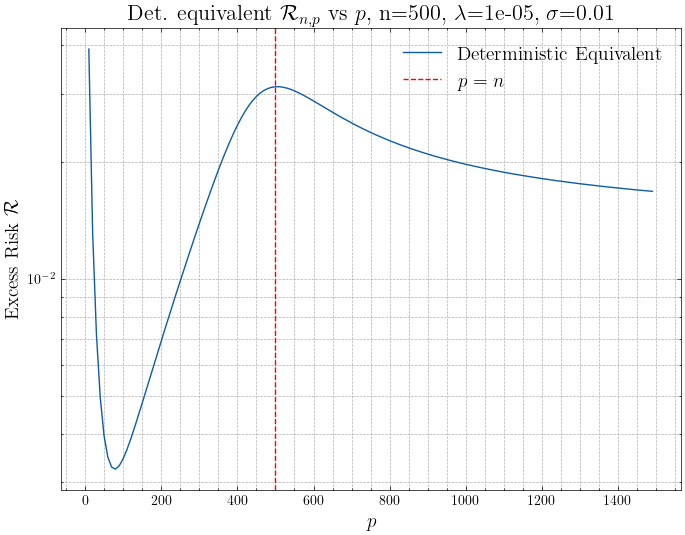

In [3]:
lambd = 1e-5
cutoff = 10**5
n = 500
alpha = 1.2
gamma = 1.4
Sigma = np.array([i**(-2*alpha) for i in range(1, cutoff+1)])
beta = np.array([i**(-gamma) for i in range(1, cutoff+1)])

pValues = np.arange(10, 1500, 10)
detEquiv = np.zeros(len(pValues))
for i, p in enumerate(pValues):
    Var, Bias = computeDeterministicEquivalent(n, p, lambd, 0.1, Sigma, beta)
    detEquiv[i] = Var + Bias
    
plt.figure(figsize=(8,6))
plt.plot(pValues, detEquiv, label="Deterministic Equivalent")
plt.xlabel("$p$", fontsize=14)
plt.ylabel("Excess Risk $\mathcal{R}$", fontsize=14)
plt.axvline(x=n, color='r', linestyle='--', label="$p = n$")
plt.yscale("log")
plt.title(f"Det. equivalent $\mathcal{{R}}_{{n,p}}$ vs $p$, n={n}, $\lambda$={lambd}, $\sigma$=0.01", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

When $p = n$, we observe the characteristic _interpolation peak_

### Step 3: generating the training set (and the model)
The feature matrix $Z$ of the RF model only sees the "feature representation" version of the vectors $\vec x, \vec w$, i.e. (Appendix B.1 Preliminaries):
$$
Z = \frac{1}{\sqrt{p}} GF^T
$$
where:
$$
\vec g_i = (\psi_k(\vec x_i))_k \>\>\>\>\>\>\>\> \vec f_j = (\xi_k \phi_k(\vec w_j))_k
$$
truncating at the mode $k = cutoff$.
Hence (Appendix C.2 Gaussian Design) if we sample:
$$
\vec g_i \sim \mathcal{N}(0, \mathcal{1}_n) \>\>\>\>\>\>\>\> \vec f_j \sim \mathcal{N}(0, \Sigma)
$$
then the target $\Sigma$ is recovered via:
$$
\Sigma = \mathbb{E}(diag\langle \vec f , \vec f \rangle) \approx diag\Bigl(\frac{1}{p}\sum_i^p \langle \vec f_i, \vec f_i\rangle\Bigr)
$$
This is a change of perspective: instead of sampling $\vec w$ and $\vec x$ from their distribution and painfully try to compute the eigenbasis and eigenvalues, we assume the feature representation of $\vec w$ and $\vec x$ (i.e. $\vec f_j, \vec g_i$) to be Gaussian IID and ignore what the actual distribution of $\vec x, \vec w$ looks like. This way, we have succesfully built a pair (training set + random weight) whose operator $\mathbb{T}$ has the desider spectrum.

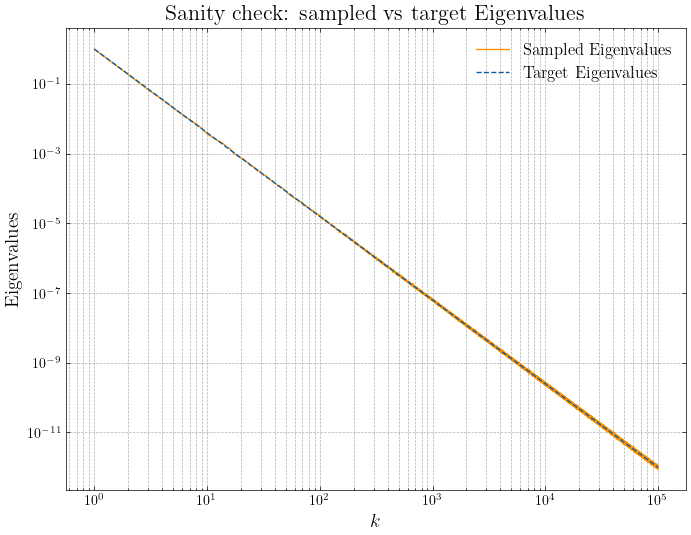

In [4]:
def generateSyntheticTraining(n : int, p : int, cutoff : int, Sigma : np.array):
    # Training points "lifted" in the feature space (up to the cutoff mode)
    G = np.random.randn(n, cutoff)
    # F matrix (representing the random features)
    F = np.random.randn(p, cutoff) * np.sqrt(Sigma)
    # The feature matrix Z, i.e. the activation of the random feature-neurons for each training point
    Z = (1/np.sqrt(p)) * G @ F.T
    return G, F, Z

G, F, Z = generateSyntheticTraining(n, p, cutoff, Sigma)
# Let's verify whether the sampled eigenvalues are, on average, compatible with the target Sigma
sampledEigenvalues = np.zeros(cutoff)
for i in np.arange(p):
    sampledEigenvalues += F[i]**2 / p

plt.figure(figsize=(8,6))
plt.loglog(np.arange(1, cutoff+1), sampledEigenvalues, label="Sampled Eigenvalues", color='C2')
# Reference line
plt.loglog(np.arange(1, cutoff+1), Sigma, linestyle='--', label="Target Eigenvalues", color='C0')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Eigenvalues", fontsize=14)
plt.title("Sanity check: sampled vs target Eigenvalues", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

### Step 4: training the RF model

The training set $\vec x_i$ got mapped into $\vec z_i \in \mathbb{R}^p$. The correct labels in the _feature picture_ are given by (Appendix B.1):
$$
y_i = \sum_k \beta_{\star, k} (\vec g_i)_k + \varepsilon_i  
$$

In this feature space, the model is simply a linear predictor:
$$
\hat f(\vec g) = \frac{1}{\sqrt{p}} \vec g^T \mathbf{F}^T \vec a
$$
and $\vec a$ is obtained as usual in a linear regression problem:
$$
\vec a = (\mathbf{Z}^T \mathbf{Z} + \lambda)^{-1} \mathbf{Z}^T \vec y
$$
The test error = test bias + test variance are given in Eq. (64), (65): let's try to obtain those errors for a random choice of $\mathbf{G}, \mathbf{F}$

In [5]:
def testModel(n, p, cutoff, Sigma, beta, lambd, noise_std=0.1):
    # Generate random training data and random weights in the "feature picture"
    G, F, Z = generateSyntheticTraining(n, p, cutoff, Sigma)
    y = (1/np.sqrt(p)) * G @ beta + noise_std * np.random.randn(n)
    # Compute the finite covariance matrix of the feature-transformed points
    Sigma_F = (1/p) * F @ F.T

    biasEmpirical = beta - (1/np.sqrt(p)) * F.T @ np.linalg.inv(Z.T @ Z + lambd * np.eye(p)) @ (Z.T) @ G @ beta
    biasEmpirical = np.linalg.norm(biasEmpirical)**2
    
    tmp = np.linalg.inv(Z.T @ Z + lambd * np.eye(p))
    varianceEmpirical = noise_std**2 * np.trace(Sigma_F @ Z.T @ Z @ tmp @ tmp)
    
    return varianceEmpirical, biasEmpirical 

Finally, iterating over a range of $p$ values, let's see whether the empirical test errors and the deterministic equivalent are in agreement:

In [6]:
# Fix the remaining free parameters
lambd = 1e-5
cutoff = 10**4
n = 500
alpha = 1.2
gamma = 1.4
noise = 0.1
Sigma = np.array([i**(-2*alpha) for i in range(1, cutoff+1)])
beta = np.array([i**(-gamma) for i in range(1, cutoff+1)])

pValues = np.arange(10, 1200, 50)
detEquivBias = np.zeros(len(pValues))
testErrorsBias = np.zeros(len(pValues))
detEquivVar = np.zeros(len(pValues))
testErrorsVar = np.zeros(len(pValues))
for i, p in enumerate(pValues):
    # Compute deterministic equivalent for this configuration
    Var, Bias = computeDeterministicEquivalent(n, p, lambd, noise, Sigma, beta)
    # Train and test
    VarEmp, BiasEmp = testModel(n, p, cutoff, Sigma, beta, lambd, noise_std=noise)
    testErrorsBias[i] = BiasEmp
    detEquivBias[i] = Bias

    testErrorsVar[i] = VarEmp
    detEquivVar[i] = Var

detEquivTotal = detEquivBias + detEquivVar
testErrorsTotal = testErrorsBias + testErrorsVar

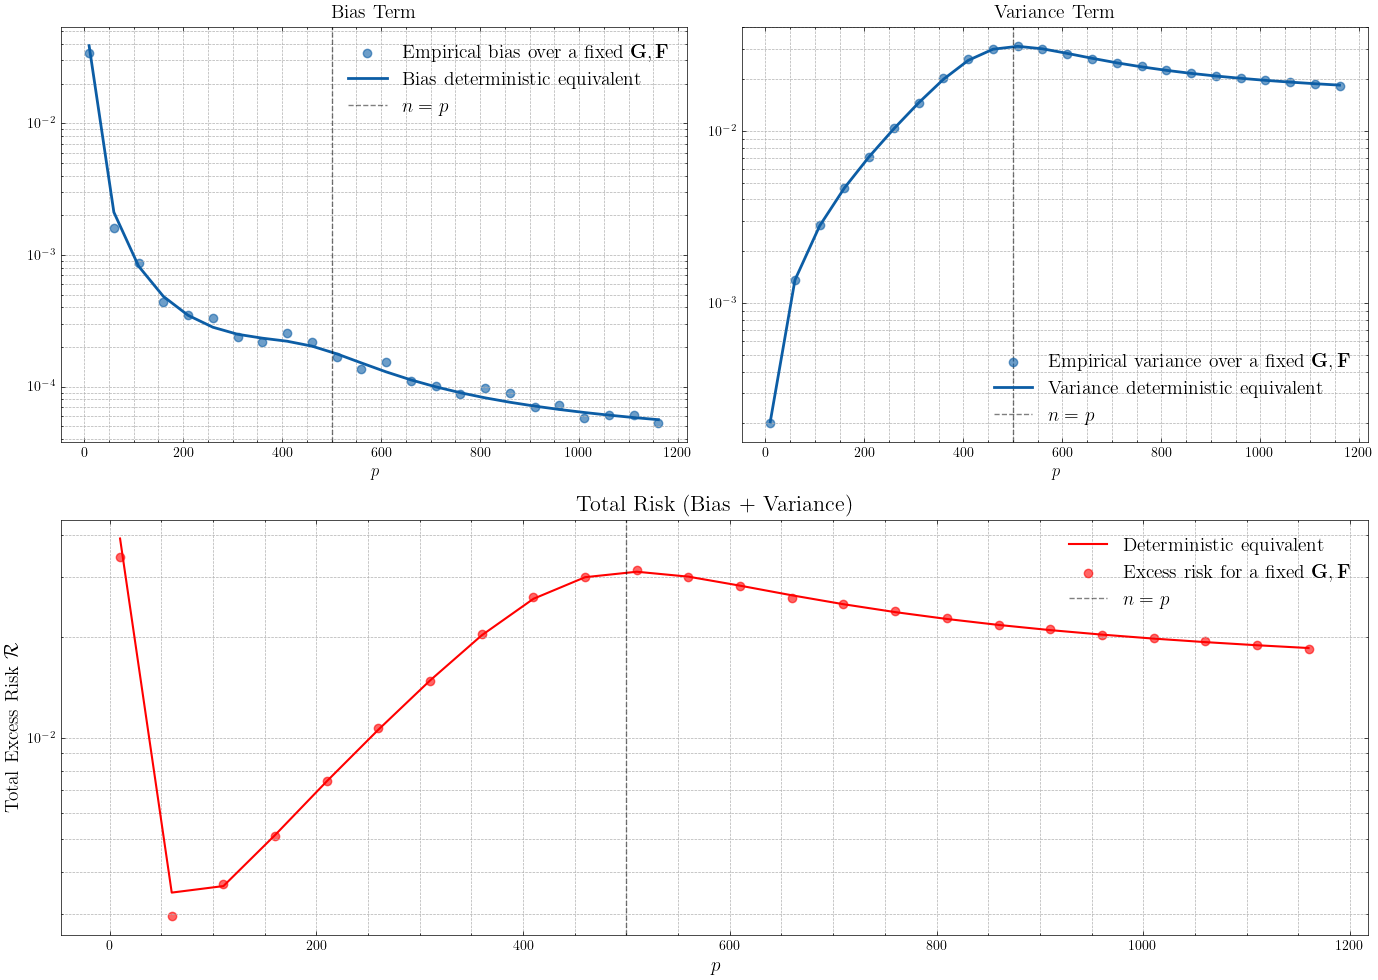

In [ ]:
# Matplot stuff, to plot the previous cell
plt.figure(figsize=(14, 10)) 
plt.subplot(2, 2, 1)
plt.scatter(pValues, testErrorsBias, label="Empirical bias over a fixed $\mathbf{G}, \mathbf{F}$", alpha=0.6)
plt.plot(pValues, detEquivBias, '-', label="Bias deterministic equivalent", linewidth=2)
plt.xlabel("$p$", fontsize=12)
plt.axvline(x=n, color='k', linestyle='--', alpha=0.5, label="$n=p$")
plt.yscale("log")
plt.title("Bias Term", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)

plt.subplot(2, 2, 2)
plt.scatter(pValues, testErrorsVar, label="Empirical variance over a fixed $\mathbf{G}, \mathbf{F}$", alpha=0.6)
plt.plot(pValues, detEquivVar, '-', label="Variance deterministic equivalent", linewidth=2)
plt.xlabel("$p$", fontsize=12)
plt.axvline(x=n, color='k', linestyle='--', alpha=0.5, label="$n=p$")
plt.yscale("log")
plt.title("Variance Term", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)

plt.subplot(2, 1, 2) 
plt.plot(pValues, detEquivTotal, 'r-', label="Deterministic equivalent", linewidth=1.5)
plt.scatter(pValues, testErrorsTotal, c='r', label="Excess risk for a fixed $\mathbf{G}, \mathbf{F}$", alpha=0.6)
plt.xlabel("$p$", fontsize=14)
plt.ylabel("Total Excess Risk $\mathcal{R}$", fontsize=14)
plt.axvline(x=n, color='k', linestyle='--', alpha=0.5, label="$n=p$")
plt.yscale("log")
plt.title("Total Risk (Bias + Variance)", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
#plt.savefig("detEquivRFRR.pdf")
plt.show()